<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
len(X_train)

60000

In [4]:
len(X_test)

10000

In [5]:
X_train[0].shape

(28, 28)

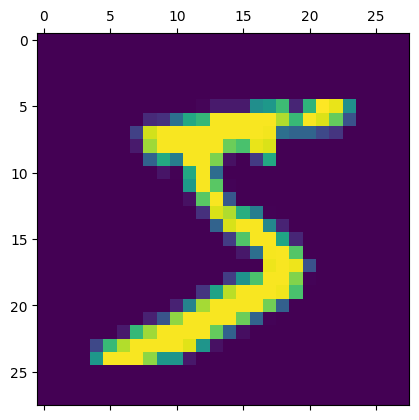

In [6]:
plt.matshow(X_train[0])

In [7]:
y_train[0]

5

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [10]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [27]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8724 - loss: 0.4567
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9632 - loss: 0.1235
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9722 - loss: 0.0903
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9808 - loss: 0.0642
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9849 - loss: 0.0495


In [28]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9713 - loss: 0.0946


[0.08130819350481033, 0.9746000170707703]

In [21]:
# Save the model in HDF5 format
model.save("content/saved_model.h5")

In [22]:
%cd content/saved_model

/content/content/saved_model


In [23]:
%ls

saved_model.h5


In [29]:
# Load the model from HDF5 format
model = tf.keras.models.load_model("content/saved_model.h5")

<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp1oc49sgn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136679706451936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991454352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991451712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991456464: TensorSpec(shape=(), dtype=tf.resource, name=None)


**With quantization**

In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Saved artifact at '/tmp/tmpifso74ix'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136679706451936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991454352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991451712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136678991456464: TensorSpec(shape=(), dtype=tf.resource, name=None)


Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [33]:
len(tflite_model)

319976

In [34]:
len(tflite_quant_model)

86040

You can see above that quantizated model is 1/4th the size of a non quantized model

In [ ]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 28, 28)            3         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 784)               1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 100)               78505     
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 10)                1015      
Total params: 79,524
Trainable params: 79,510
Non-trainable params: 14
_________________________________________________________________


In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0438 - accuracy: 0.9866


In [ ]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9755


[0.08016839623451233, 0.9754999876022339]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


INFO:tensorflow:Assets written to: C:\Users\dhava\AppData\Local\Temp\tmpqnsx4bvx\assets


In [ ]:
len(tflite_qaware_model)

82376

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

## Example: Applying Quantization to a Saved Model

Let’s walk through a step-by-step example of how to apply both Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT) to a saved model, converting it from float32 to int8.

### Step 1: Load the Saved Model

Assume you have a trained model saved in a file format (like TensorFlow SavedModel or PyTorch). First, you need to load the model.

```python
# Example for TensorFlow
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('path_to_saved_model')
```

### Step 2: Post-Training Quantization (PTQ)

#### 2.1: Prepare the Calibration Dataset

To perform PTQ, you need a small dataset that represents the data your model will encounter in production. This dataset is used to calibrate the quantization parameters.

```python
# Prepare a representative dataset
calibration_data = [...]  # Load or create a small representative dataset
```

#### 2.2: Apply Post-Training Quantization

Using TensorFlow’s `tf.quantization` API, you can apply PTQ to the loaded model.

```python
# Convert the model to a quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide the representative dataset for calibration
def representative_dataset_gen():
    for input_data in calibration_data:
        yield [input_data]

converter.representative_dataset = representative_dataset_gen

# Convert the model
quantized_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)
```

### Step 3: Quantization-Aware Training (QAT)

#### 3.1: Modify the Model for QAT

To prepare for QAT, you need to modify your model to include fake quantization layers. This simulates the quantization effects during training.

```python
import tensorflow_model_optimization as tfmot

# Create a quantization-aware model
qat_model = tfmot.quantization.keras.quantize_model(model)

# Compile the model
qat_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
```

#### 3.2: Fine-Tune the Model

Fine-tune the quantization-aware model using your training dataset. This helps the model adjust to the quantization effects.

```python
# Fine-tune the model
qat_model.fit(training_data, training_labels, epochs=5, validation_data=(validation_data, validation_labels))
```

#### 3.3: Convert the QAT Model to INT8

After fine-tuning, you can convert the quantization-aware model to INT8.

```python
# Convert the QAT model to a quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
quantized_qat_model = converter.convert()

# Save the quantized QAT model
with open('quantized_qat_model.tflite', 'wb') as f:
    f.write(quantized_qat_model)
```

### Summary of the Process

1. **Load the Saved Model**: Load your pre-trained float32 model.
2. **Post-Training Quantization (PTQ)**:
   - Prepare a representative dataset.
   - Convert the model to a quantized version using the calibration dataset.
3. **Quantization-Aware Training (QAT)**:
   - Modify the model to include fake quantization layers.
   - Fine-tune the model with your training data.
   - Convert the quantization-aware model to a quantized version.

### Conclusion

In this example, we demonstrated how to apply both PTQ and QAT to convert a float32 model to an int8 model. PTQ is simpler and quicker, while QAT can yield better accuracy by training the model with quantization effects in mind. Depending on your application and requirements, you can choose the method that best fits your needs.

# Binary Quantization

As a result, in practice quantizing a float32 embedding with a dimensionality of 1024 yields an int8 or uint8 embedding with a dimensionality of 128. See two approaches of how you can produce quantized embeddings using Sentence Transformers below:



In [36]:
!pip install sentence-transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [41]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

model= SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
bin_embeddings= model.encode(
    ["I am driving to the lake.", "It is a beautiful day."],
    precision="binary",
)

# 2b. or, encode some text without quantization & apply quantization afterwards
embeddings = model.encode(["I am driving to the lake.", "It is a beautiful day."])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [49]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings

# 1. Load an embedding model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

# 2a. Encode some text using "binary" quantization
binary_embeddings = model.encode(
    ["I am driving to the lake.", "It is a beautiful day."],
    precision="binary",
)

# 2b. or, encode some text without quantization & apply quantization afterwards
embeddings = model.encode(["I am driving to the lake.", "It is a beautiful day."])
binary_embeddings = quantize_embeddings(embeddings, precision="binary")

In [44]:
embeddings.shape, embeddings.nbytes, embeddings.dtype, bin_embeddings.shape, bin_embeddings.nbytes, bin_embeddings.dtype,

((2, 1024), 8192, dtype('float32'), (2, 128), 256, dtype('int8'))

In [50]:
binary_embeddings[1], embeddings[1]

(array([ -61,   60,  -44,  108,   58,   32,   81,  -42,   89,  -43, -109,
          59,   -1,  -55,  124,  -31,  -28,  -55,  116,   81,  -40,  -77,
         123, -126,   80,  -37,  106,   79,    9,  126,  102,  109,  102,
          81, -117,  -97,   84,  -52,  -51,   27, -106,  -57,   25,  -43,
        -112,  123,   52,   11,   66,    8,  -13,   15,  -47,  -87,  -40,
          67,   40,  -17,  -33,   32,  -93,  -30,  -83, -106,  -65,   60,
        -127,  -16,   -1,  -86,  -64,   12, -103,   88,   84,  -36,   86,
         -90, -107,  -12,   15,  -69, -100,   16,  -67,    4,   13,   62,
         -88,  -95,  104,   90, -115,  -96,   38,   16,  -38,   18,  -67,
          14,  -40,   48,  106,  106,   90,  -59,   31,  -32,   50,  -46,
         -76,   19,  -50,   56,   28,  -83,  -45,  -43,   19,    1,  -54,
          98,   86,   81,   49,  -37,   78,   57], dtype=int8),
 array([-0.76368487,  0.5963272 , -0.03957352, ..., -0.06096254,
        -0.03604766,  0.15181684], dtype=float32))

# Scaler Quantization

In [50]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings
from datasets import load_dataset

# 1. Load an embedding model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

# 2. Prepare an example calibration dataset
corpus = load_dataset("nq_open", split="train[:1000]")["question"]
calibration_embeddings = model.encode(corpus)

# 3. Encode some text without quantization & apply quantization afterwards
embeddings = model.encode(["I am driving to the lake.", "It is a beautiful day."])
int8_embeddings = quantize_embeddings(
    embeddings,
    precision="int8",
    calibration_embeddings=calibration_embeddings,
)